Bài toán đặt ra là dự báo doanh số bán hàng trong tương lai tại các cửa hàng bán lẻ. Tập dữ liệu được sử dụng trong notebook này chứa thông tin về doanh số bán hàng trong quá khứ cùng các thông tin đi kèm của một công ty có tên là Corporación Favorita, một nhà bán lẻ thực phẩm lớn ở Ecuador . Công ty này cũng hoạt động ở các quốc gia khác ở Nam Mỹ. Tập dữ liệu này được lấy từ một cuộc thi công khai trên trang web Kaggle. Vì vậy có thể đưa ra các giải pháp và đánh giá hiệu quả của mô hình so với những người khác cùng tham gia cuộc thi này.

Đường dẫn của cuộc thi  -> https://www.kaggle.com/competitions/store-sales-time-series-forecasting


<img src="https://raw.githubusercontent.com/EkremBayar/Kaggle/refs/heads/main/Images/CF.png" width="25%" />
<img src="https://raw.githubusercontent.com/EkremBayar/Kaggle/refs/heads/main/Images/CF1.jpg" width="35%" />


Tập dữ liệu gồm có **54 cửa hàng** và **33 nhóm sản phẩm**. Chuỗi thời gian bắt đầu từ **2013-01-01** và kết thúc vào **2017-08-31**. Trong đó, **15 ngày** cuối cùng là những ngày chúng ta phải dự đoán doanh thu (tức là từ **2017-08-16** đến **2017-08-31** chưa cho biết doanh thu).

Tập dữ liệu chia thành 6 tập con:

1. _Train_
2. _Test_
3. _Store_
4. _Transactions_
5. _Holidays and Events_
6. _Daily Oil Price_

**Train** là tập chứa chuỗi thời gian của các tổ hợp cửa hàng và nhóm sản phẩm. Cột `sales` cung cấp tổng doanh số bán hàng của một nhóm sản phẩm tại một cửa hàng vào một ngày cụ thể. Cột `onpromotion` cho biết tổng số sản phẩm trong một nhóm đang được khuyến mãi tại một cửa hàng vào một ngày cụ thể.

**Store** cung cấp thông tin về các cửa hàng như thành phố (city), tiểu bang (state), loại cửa hàng (type), và cụm (cluster).

**Transaction** có mối tương quan cao với cột `sales` trong tập **Train**. Dữ liệu này giúp hiểu được số lượng mặt hàng được bán tại các cửa hàng.

**Holidays and Events data** là siêu dữ liệu. Nó cho biết thông tin về các ngày lễ ở Ecuador, rất hữu ích cho phân tích doanh số.

**Daily Oil Price** là một dữ liệu bổ sung. Theo như mô tả, **Ecuador** là một quốc gia phụ thuộc vào dầu mỏ và tình hình kinh tế của họ dễ bị ảnh hưởng bởi biến động giá dầu. Vì vậy, dữ liệu này có thể giúp hiểu nhóm sản phẩm nào bị ảnh hưởng tích cực hoặc tiêu cực bởi giá dầu.

Tập dữ liệu có một vài “Ghi chú bổ sung”. Những ghi chú này có thể rất quan trọng để nhận ra các mẫu hoặc điểm bất thường. Dưới đây là một vài ghi chú quan trọng:
- Lương trong khu vực công được trả hai tuần một lần, vào ngày 15 và vào ngày cuối cùng của tháng. Doanh số bán hàng tại siêu thị có thể bị ảnh hưởng bởi điều này.
- Một trận động đất mạnh 7,8 độ đã xảy ra ở Ecuador vào ngày 16 tháng 4 năm 2016. Người dân đã tham gia vào các hoạt động cứu trợ, quyên góp nước và các nhu yếu phẩm khác, làm tăng đáng kể doanh số bán hàng tại siêu thị trong vài tuần sau đó.


# Khai báo thư viện

In [1]:
!pip install statsmodels

In [2]:
!pip install xgboost


In [3]:
!pip install lightgbm

In [4]:
!pip install catboost


In [5]:
import pandas as pd

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.express as px

from IPython.display import display, Markdown, HTML

from scipy.stats import chi2, chi2_contingency

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.preprocessing import RobustScaler, LabelEncoder, MinMaxScaler

from sklearn.preprocessing import PolynomialFeatures

from statsmodels.tsa.deterministic import DeterministicProcess,CalendarFourier

from scipy.signal import periodogram

import statsmodels.api as sm

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

from sklearn.multioutput import RegressorChain

import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Tiền xử lí dữ liệu

In [6]:
import gdown

url = 'https://drive.google.com/uc?id=1jf2PFQl0p8Um9G_IbE1Bnk3xezyJG8kA'
output = 'train_data.csv'
gdown.download(url, output, quiet=False)

df_train = pd.read_csv(output)
df_test = pd.read_csv('https://drive.google.com/uc?id=1k_f609mLy5a8XD63zhNCf1g3uQW0LCcJ')
df_store = pd.read_csv('https://drive.google.com/uc?id=1sXVWpg7k5U-7R_8VbVbMgoohI9XKTasU')
df_transaction = pd.read_csv('https://drive.google.com/uc?id=1rd1j7ziuka_I3M4q2Q_8HBsQJGmjbdBC')
df_holiday = pd.read_csv('https://drive.google.com/uc?id=1XVD2RGiKLqT1J48SaMK2HIHUNX3ZXTjq')
df_oil = pd.read_csv('https://drive.google.com/uc?id=19fSYyNrhXrhljPwrWR10kcCt6Iir8XoG')

Downloading...
From (original): https://drive.google.com/uc?id=1jf2PFQl0p8Um9G_IbE1Bnk3xezyJG8kA
From (redirected): https://drive.google.com/uc?id=1jf2PFQl0p8Um9G_IbE1Bnk3xezyJG8kA&confirm=t&uuid=f0cc562d-3ec9-4bb2-861e-61079cbc5227
To: /content/train_data.csv
100%|██████████| 122M/122M [00:14<00:00, 8.65MB/s]


Tập **Train**

In [7]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [8]:
display(Markdown(f"Số bản ghi của tập train : {df_train.shape[0]}"))

Số bản ghi của tập train : 3000888

Tập **Test**

In [9]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [10]:
display(Markdown(f"Số bản ghi của tập test : {df_test.shape[0]}"))

Số bản ghi của tập test : 28512

Tập **Store**

In [11]:
df_store.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [12]:
display(Markdown(f"Số bản ghi của tập store : {df_store.shape[0]}"))

Số bản ghi của tập store : 54

Tập **Transaction**

In [13]:
df_transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [14]:
display(Markdown(f"Số bản ghi của tập transaction : {df_transaction.shape[0]}"))

Số bản ghi của tập transaction : 83488

Tập **Holiday and Events**

In [15]:
df_holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [16]:
display(Markdown(f"Số bản ghi của tập holiday : {df_holiday.shape[0]}"))

Số bản ghi của tập holiday : 350

Tập **Daily Oil Price**

In [17]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [18]:
display(Markdown(f"Số bản ghi của tập oil : {df_oil.shape[0]}"))

Số bản ghi của tập oil : 1218

Tập **store**, **transaction**, **holiday** và **oil** là các tập dữ liệu bổ sung cho tập **train**

## Tập dữ liệu Train

Kiểm tra giá trị bị thiếu trên từng cột thuộc tính

In [19]:
df_train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0


Tất cả đều trả về 0

Dữ liệu trong tập **Train** bắt đầu từ **2013-01-01** đến **2017-08-15**

In [20]:
display(Markdown(f"Số ngày trong tập train là : {df_train['date'].nunique()}"))

Số ngày trong tập train là : 1684

In [21]:
df_train['date'] = pd.to_datetime(df_train['date'])
full_date_range = pd.date_range(start=df_train['date'].min(), end=df_train['date'].max(), freq='D')
missing_dates = full_date_range.difference(df_train['date'])
missing_dates_str = [date.strftime('%Y-%m-%d') for date in missing_dates]
display(Markdown(f"Những ngày bị thiếu: {', '.join(missing_dates_str)}"))

Những ngày bị thiếu: 2013-12-25, 2014-12-25, 2015-12-25, 2016-12-25

Tập dữ liệu thiếu các ngày 25/12 hàng năm

In [22]:
display(Markdown(f"Danh sách các store : {', '.join(map(str, df_train['store_nbr'].sort_values().unique()))}"))


Danh sách các store : 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54

In [23]:
print(f"Danh sách các nhóm mặt hàng {df_train['family'].unique()}")


Danh sách các nhóm mặt hàng ['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']


Cột `onpromotion` (số sản phẩm khuyến mãi) chiếm chủ yếu là 0

In [24]:
display(Markdown(f"Số bản ghi có giá trị là 0 chiếm {(df_train[df_train['onpromotion']==0].shape[0]* 100 / len(df_train)):.2f} % trong toàn bộ tập dữ liệu"))

Số bản ghi có giá trị là 0 chiếm 79.63 % trong toàn bộ tập dữ liệu

In [25]:
display(Markdown(f"Miền giá trị của doanh thu : {df_train['sales'].min():.0f} - {df_train['sales'].max():.0f} "))

Miền giá trị của doanh thu : 0 - 124717 

In [26]:
# Chuyển kiểu dữ liệu
df_train['id'] = df_train['id'].astype('uint32')
df_train['store_nbr'] = df_train['store_nbr'].astype('category')
df_train['family'] = df_train['family'].astype('category')
df_train['sales'] = df_train['sales'].astype('float32')
df_train['onpromotion'] = df_train['onpromotion'].astype('uint32')

## Tập dữ liệu Test

Chứa chuỗi thời gian bắt đầu từ **2017-08-16** đến **2017-08-31** và thiếu đi cột doanh thu so với tập **train**

In [27]:
# chuyển kiểu dữ liệu

df_test['id'] = df_test['id'].astype('uint32')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['store_nbr'] = df_test['store_nbr'].astype('category')
df_test['family'] = df_test['family'].astype('category')
df_test['onpromotion'] = df_test['onpromotion'].astype('uint32')

## Tập dữ liệu Store

In [28]:
display(Markdown(
    ' **Các thành phố** :  \n' +
    '\n'.join(sorted(df_store['city'].unique())) +
    '\n\n **Các tiểu bang** : \n\n' +
    '\n'.join(sorted(df_store['state'].unique())) +
    '\n\n **Các kiểu cửa hàng** :  \n' +
    '\n'.join(sorted(df_store['type'].unique())) +
    '\n\n **Các nhóm cửa hàng** :  \n' +
    '\n'.join(map( str, sorted(df_store['cluster'].unique())))
))


 **Các thành phố** :  
Ambato
Babahoyo
Cayambe
Cuenca
Daule
El Carmen
Esmeraldas
Guaranda
Guayaquil
Ibarra
Latacunga
Libertad
Loja
Machala
Manta
Playas
Puyo
Quevedo
Quito
Riobamba
Salinas
Santo Domingo

 **Các tiểu bang** : 

Azuay
Bolivar
Chimborazo
Cotopaxi
El Oro
Esmeraldas
Guayas
Imbabura
Loja
Los Rios
Manabi
Pastaza
Pichincha
Santa Elena
Santo Domingo de los Tsachilas
Tungurahua

 **Các kiểu cửa hàng** :  
A
B
C
D
E

 **Các nhóm cửa hàng** :  
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17

In [29]:
# đổi kiểu dữ liệu
df_store = df_store.apply(lambda x: x.astype('category'))

## Tập dữ liệu Transaction

In [30]:
display(Markdown(f"Ngày nhỏ nhất: {df_transaction['date'].min()}  \nNgày lớn nhất: {df_transaction['date'].max()}"))

Ngày nhỏ nhất: 2013-01-01  
Ngày lớn nhất: 2017-08-15

Tập transaction không chứa số giao dịch trong tập test.

In [31]:
# chuyển đổi kiểu dữ liệu

df_transaction['date'] = pd.to_datetime(df_transaction['date'])
df_transaction['store_nbr'] = df_transaction['store_nbr'].astype('category')
df_transaction['transactions'] = df_transaction['transactions'].astype('uint32')

In [32]:
df_train_grouped = df_train.groupby(['store_nbr', 'date'])['sales'].sum().reset_index()
missing_dates = pd.merge(df_train_grouped, df_transaction[['store_nbr', 'date']], on=['store_nbr', 'date'], how='left', indicator=True)
missing_dates = missing_dates[missing_dates['_merge'] == 'left_only'].drop('_merge', axis=1)

zero_sales_days = len(missing_dates[missing_dates['sales'] == 0])
non_zero_sales_days = len(missing_dates[missing_dates['sales'] != 0])
total_rec = 54 * 1684
curr_rec = len(df_transaction.index)
print(
    f"Tổng số giao dịch lí thuyết: {total_rec}",
    "\n",
    f"Số giao dịch hiện tại: {curr_rec}",
    "\n",
    f"Số giao dịch bị thiếu với doanh thu bằng 0: {zero_sales_days}",
    "\n",
    f"Số giao dịch bị thiếu với doanh thu khác 0: {non_zero_sales_days}",
)

Tổng số giao dịch lí thuyết: 90936 
 Số giao dịch hiện tại: 83488 
 Số giao dịch bị thiếu với doanh thu bằng 0: 7330 
 Số giao dịch bị thiếu với doanh thu khác 0: 118


Tất cả có 54 store và 1684 ngày nên chúng ta sẽ có tổng 90936 bản ghi giao dịch. Nhưng lại chỉ có 83488 bản ghi, tức là một số bản ghi bị thiếu. Trong đó:
- Số giao dịch có doanh thu bằng 0 chúng ta có thể hiểu là số giao dịch cũng sẽ là 0 cho nên người thu thập dữ liệu có thể không ghi lại các ngày đó.
- Còn lại một số ngày (118) số giao dịch thực sự bị thiếu. Chúng ta sẽ sử dụng nội suy tuyến tính thông qua các giá trị liền trước và liền sau nó.

In [33]:

df_transaction = df_transaction.merge(
    df_train_grouped,
    on=["date", "store_nbr"],
    how="outer",
).sort_values(["date", "store_nbr"], ignore_index=True)

df_transaction.loc[df_transaction.sales.eq(0), "transactions"] = 0.
df_transaction = df_transaction.drop(columns=["sales"])

df_transaction.transactions = df_transaction.groupby("store_nbr", group_keys=False).transactions.apply(
    lambda x: x.interpolate(method="linear", limit_direction="both")
)

## Tập dữ liệu Holiday

In [34]:
df_holiday.sample(3)

,date,type,locale,locale_name,description,transferred
132,2014-08-24,Holiday,Local,Ambato,Fundacion de Ambato,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
330,2017-10-07,Holiday,Local,Quevedo,Cantonizacion de Quevedo,False


In [35]:

display(Markdown(f"Ngày nhỏ nhất: {df_holiday['date'].min()}  \nNgày lớn nhất: {df_holiday['date'].max()}"))

Ngày nhỏ nhất: 2012-03-02  
Ngày lớn nhất: 2017-12-26

Tập dữ liệu của chúng ta đi từ '2013-01-01' đến '2017-08-31' cho nên những ngày không trong khoảng thời gian này sẽ loại bỏ

Tập holiday chứa cả ngày lễ trên tập test (2017-08-16 đến 2017-08-31)

In [36]:
df_holiday = df_holiday[(df_holiday['date'] >= '2013-01-01')& (df_holiday['date'] <= '2017-08-31')]


In [37]:
display(Markdown(
    '**Các loại ngày lễ:**  \n ' +
    ', '.join(sorted(df_holiday['type'].unique())) +
    '\n\n**Phạm vi khu vực:** \n\n ' +
    ', '.join(sorted(df_holiday['locale'].unique())) +
    '\n\n**Tên khu vực:**  \n ' +
    ', '.join(sorted(df_holiday['locale_name'].unique()))
))


**Các loại ngày lễ:**  
 Additional, Bridge, Event, Holiday, Transfer, Work Day

**Phạm vi khu vực:** 

 Local, National, Regional

**Tên khu vực:**  
 Ambato, Cayambe, Cotopaxi, Cuenca, Ecuador, El Carmen, Esmeraldas, Guaranda, Guayaquil, Ibarra, Imbabura, Latacunga, Libertad, Loja, Machala, Manta, Puyo, Quevedo, Quito, Riobamba, Salinas, Santa Elena, Santo Domingo, Santo Domingo de los Tsachilas

Các loại ngày lễ :

- Holiday : Ngày lễ

- Event : Sự kiện

- Transfer : Là một ngày lễ/ sự kiện đã được chuyển

- Bridge : Ngày cầu nối

- Additional : Ngày lễ bổ sung

- Work Day : Ngày đi làm



❎ LƯU Ý:

- Cột `transferred` biểu thị ngày lễ/ sự kiện hôm đó có được chuyển hay không. Một ngày gọi là được chuyển khi theo lịch chính thức ngày lễ/ sự kiện đó rơi vào ngày dương lịch đó, nhưng đã được chính phủ chuyển sang một ngày khác. Ngày được chuyển như này giống một ngày bình thường hơn là một ngày lễ. Những ngày được chuyển sẽ có `type` là _Transfer_



  (ví dụ: Ngày lễ '_Independencia de Guayaquil_ ' đã được chuyển từ ngày 09/10/2012 sang ngày 12/10/2012, nghĩa là ngày này được tổ chức vào ngày 12/10/2012).

- Những ngày thuộc `type` là _Bridge_ là những ngày bổ sung được thêm vào một ngày lễ/ sự kiện (ví dụ: lịch nghỉ lễ là thứ 4 và thứ 5, thì sẽ có thêm ngày Bridge là thứ 6. Kết quả là sẽ nghĩ liên tục từ thứ 4 đến chủ nhật).

- Ngày có `type` là _Work Day_, là một ngày thường không được lên lịch làm việc (ví dụ: Thứ Bảy) nhưng vẫn phải đi làm. Ngày này nhằm mục đích bù lại ngày _Bridge_ .

- Các ngày lễ bổ sung (Addtional) là những ngày được thêm vào một ngày lễ lịch thông thường, ví dụ, thường xảy ra vào khoảng Giáng sinh (biến Đêm Giáng sinh thành một ngày lễ ).

Giá trị của từng `locale_name` tương ứng với từng `locale`

In [38]:
national_locale_name = sorted(df_holiday[df_holiday.locale.eq("National")].locale_name.unique().tolist())
regional_locale_name = sorted(df_holiday[df_holiday.locale.eq("Regional")].locale_name.unique().tolist())
local_locale_name = sorted(df_holiday[df_holiday.locale.eq("Local")].locale_name.unique().tolist())
print(
    "Locale names for national holidays:",
    national_locale_name,
    "\n",
    "Locale names for regional holidays:",
    regional_locale_name,
    "\n",
    "Locale names for local holidays:",
    local_locale_name,
)

Locale names for national holidays: ['Ecuador'] 
 Locale names for regional holidays: ['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas'] 
 Locale names for local holidays: ['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


Nhận thấy:

- National : Quốc gia, `locale_name` tương ứng là Ecuador ( do tập dữ liệu chỉ giới hạn trong lãnh thổ Ecuador)

- Regional : Khu vực, `locale_name` tương ứng là các tiểu bang

- Local : Địa phương, `locale_name` tương ứng là các thành phố



↪ Như vậy, các ngày lễ chỉ có ảnh hưởng tới một số cửa hàng nhất định, do vị trí của các cửa hàng là khác nhau.

In [39]:
# chuyển đổi kiểu dữ liệu
df_holiday['date'] = pd.to_datetime(df_holiday['date'])
df_holiday['type'] = df_holiday['type'].astype('category')
df_holiday['locale'] = df_holiday['locale'].astype('category')
df_holiday['locale_name'] = df_holiday['locale_name'].astype('category')
df_holiday['description'] = df_holiday['description'].astype('category')

### Xử lí dữ liệu trên cột `type`

#### Transfer

Kiểm tra những ngày lễ bị chuyển và những ngày lễ được chuyển

In [40]:
tr1 = df_holiday[ (df_holiday.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = df_holiday[(df_holiday.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)

In [41]:
display(HTML(f"""
<div style="display: flex; justify-content: space-around;">
    <div style="flex: 0.8; padding: 10px;">
        <h3>Các ngày bị chuyển</h3>
        {tr1.to_html(index=False)}
    </div>
    <div style="flex: 0.9; padding: 10px;">
        <h3>Các ngày được chuyển</h3>
        {tr2.to_html(index=False)}
    </div>
</div>
"""))

date,type,locale,locale_name,description
2013-10-09,Holiday,National,Ecuador,Independencia de Guayaquil
2014-10-09,Holiday,National,Ecuador,Independencia de Guayaquil
2016-05-24,Holiday,National,Ecuador,Batalla de Pichincha
2016-07-25,Holiday,Local,Guayaquil,Fundacion de Guayaquil
2016-08-10,Holiday,National,Ecuador,Primer Grito de Independencia
2017-01-01,Holiday,National,Ecuador,Primer dia del ano
2017-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca
2017-05-24,Holiday,National,Ecuador,Batalla de Pichincha
2017-08-10,Holiday,National,Ecuador,Primer Grito de Independencia
date,type,locale,locale_name,description


Những ngày bị chuyển thực chất không phải ngày lễ. Chúng ta sẽ xóa các ngày đó, chỉ giữ lại các ngày đã chuyển và xóa bỏ tiền tố `Trasaldo` khỏi các ngày đó.

Xử lí xong vấn đề Transfer cho nên chúng ta sẽ bỏ đi cột `transferred`

In [42]:
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

In [43]:

display(Markdown('Các ngày sau khi chuyển'))
display(tr)

Các ngày sau khi chuyển

,date,type,locale,locale_name,description
0,2013-10-11,Holiday,National,Ecuador,Independencia de Guayaquil
1,2014-10-10,Holiday,National,Ecuador,Independencia de Guayaquil
2,2016-05-27,Holiday,National,Ecuador,Batalla de Pichincha
3,2016-07-24,Holiday,Local,Guayaquil,Fundacion de Guayaquil
4,2016-08-12,Holiday,National,Ecuador,Primer Grito de Independencia
5,2017-01-02,Holiday,National,Ecuador,Primer dia del ano
6,2017-04-13,Holiday,Local,Cuenca,Fundacion de Cuenca
7,2017-05-26,Holiday,National,Ecuador,Batalla de Pichincha
8,2017-08-11,Holiday,National,Ecuador,Primer Grito de Independencia


In [44]:
df_holiday = df_holiday[(df_holiday.transferred == False) & (df_holiday.type != "Transfer")].drop("transferred", axis = 1)


In [45]:
df_holiday = pd.concat([df_holiday, tr], ignore_index=True)

#### Additional

Kiểm tra các ngày Additional

In [46]:
df_holiday[df_holiday['type'] == 'Additional'].head(10)

,date,type,locale,locale_name,description
12,2013-05-11,Additional,National,Ecuador,Dia de la Madre-1
23,2013-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1
38,2013-12-05,Additional,Local,Quito,Fundacion de Quito-1
41,2013-12-21,Additional,National,Ecuador,Navidad-4
42,2013-12-22,Additional,National,Ecuador,Navidad-3
44,2013-12-23,Additional,National,Ecuador,Navidad-2
45,2013-12-24,Additional,National,Ecuador,Navidad-1
47,2013-12-26,Additional,National,Ecuador,Navidad+1
48,2013-12-31,Additional,National,Ecuador,Primer dia del ano-1
59,2014-05-10,Additional,National,Ecuador,Dia de la Madre-1


Các ngày additional là các ngày xung quanh một ngày lễ. Ví dụ ở trên, lần lượt có các ngày Navidad ( giáng sinh) với hậu tố -1,+1,.... Chúng ta sẽ xóa bỏ các hậu tố để đồng nhất các ngày lễ với nhau.

In [47]:
df_holiday["description"] = df_holiday["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '',  regex=True)

Và đổi Addition thành Holiday do cùng là ngày lễ

In [48]:
df_holiday["type"] = np.where(df_holiday["type"] == "Additional", "Holiday", df_holiday["type"])

#### Bridge

Kiểm tra tương tự với các ngày có `type` là Bridge

In [49]:
df_holiday[df_holiday['type'] == 'Bridge']

,date,type,locale,locale_name,description
111,2014-12-26,Bridge,National,Ecuador,Puente Navidad
115,2015-01-02,Bridge,National,Ecuador,Puente Primer dia del ano
226,2016-11-04,Bridge,National,Ecuador,Puente Dia de Difuntos


Các ngày cầu nối đều có `description` là Puente (cầu) ở tiền tố. Chúng ta sẽ xóa bỏ tiền tố để đồng nhất và đổi lại type chung thành `holiday`

In [50]:
df_holiday["description"] = df_holiday["description"].str.replace("Puente ", "")

df_holiday["type"] = np.where(df_holiday["type"] == "Bridge", "Holiday", df_holiday["type"])

#### Work Day

Những ngày Work Day là những ngày đi làm bù cho Bridge, cho nên không có ý nghĩa cho mặt doanh thu. Ta sẽ loại bỏ những ngày này khỏi tập holiday. Tuy nhiên, những ngày Work Day là những ngày cuối tuần, nơi mọi người có khả năng mua sắm cao hơn, lúc này khi tất cả mọi người đều đi làm thì khả năng doanh thu sẽ khác với cuối tuần những ngày thông thường. Chúng ta sẽ giữ lại những ngày này.

In [51]:
work_day = df_holiday[df_holiday.type == "Work Day"]

df_holiday = df_holiday[df_holiday.type != "Work Day"]

Kiểm tra tập work_day vừa tạo

In [52]:
work_day

,date,type,locale,locale_name,description
1,2013-01-05,Work Day,National,Ecuador,Recupero puente Navidad
2,2013-01-12,Work Day,National,Ecuador,Recupero puente primer dia del ano
104,2014-12-20,Work Day,National,Ecuador,Recupero Navidad
116,2015-01-10,Work Day,National,Ecuador,Recupero Primer dia del ano
232,2016-11-12,Work Day,National,Ecuador,Recupero Dia de Difuntos


In [53]:
work_day = work_day[['date','type']].rename({"type":"IsWorkDay"}, axis = 1)


#### Event

Lúc này chỉ còn 2 loại ngày lễ là Event và Holiday. Kiểm tra Event

In [54]:
df_holiday[df_holiday['type']== 'Event'].head(10)

,date,type,locale,locale_name,description
14,2013-05-12,Event,National,Ecuador,Dia de la Madre
60,2014-05-11,Event,National,Ecuador,Dia de la Madre
63,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil
64,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorSuiza
65,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorHonduras
70,2014-06-25,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorFrancia
71,2014-06-28,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final
72,2014-06-29,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final
73,2014-06-30,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final
74,2014-07-01,Event,National,Ecuador,Mundial de futbol Brasil: Octavos de Final


In [55]:
df_holiday.loc[df_holiday['type']== 'Event', 'locale'].value_counts()

,count
locale,
National,56
Local,0
Regional,0


Tất cả `type` là Event đều có locale là National. Event và Holiday thực tế là hai loại khác nhau nên chúng ta sẽ chia riêng ra

In [56]:
events = df_holiday[df_holiday.type == "Event"]

events.head()

,date,type,locale,locale_name,description
14,2013-05-12,Event,National,Ecuador,Dia de la Madre
60,2014-05-11,Event,National,Ecuador,Dia de la Madre
63,2014-06-12,Event,National,Ecuador,Inauguracion Mundial de futbol Brasil
64,2014-06-15,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorSuiza
65,2014-06-20,Event,National,Ecuador,Mundial de futbol Brasil: EcuadorHonduras


Do cột `locale` và `locale_name` giống nhau nên chúng ta sẽ xóa bỏ, và xóa bỏ `type` do tất cả đều là Event. Đồng thời thay đổi cột `description` thành `events` để phân biệt với holiday

In [57]:
events = events.drop(['locale', 'type', 'locale_name'], axis = 1).rename({"description":"events"}, axis = 1)

events.head()

,date,events
14,2013-05-12,Dia de la Madre
60,2014-05-11,Dia de la Madre
63,2014-06-12,Inauguracion Mundial de futbol Brasil
64,2014-06-15,Mundial de futbol Brasil: EcuadorSuiza
65,2014-06-20,Mundial de futbol Brasil: EcuadorHonduras


Xóa events khỏi tập holiday

In [58]:
df_holiday = df_holiday[df_holiday['type'] != "Event"].drop("type", axis=1)


### Xử lí trên cột `locale`

Tương ứng với National, Regional, Local chúng ta sẽ tách ra thành từng tập riêng để join với tập train và store sau này tương ứng với :
- National cho tất cả
- Regional cho state (tiểu bang)
- Local cho city (khu vực)

Chúng ta sẽ đổi tên cột Local và Reginal thành city và state để tương đồng với các cột của tập store

In [59]:
regional = df_holiday[df_holiday.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1)
national = df_holiday[df_holiday.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1)
local = df_holiday[df_holiday.locale == "Local"].rename({ "locale_name":"city", "description":"holiday_local"}, axis = 1).drop("locale", axis = 1)

In [60]:
regional = regional[~ regional.duplicated()]
national = national[~ national.duplicated()]
local = local[~ local.duplicated()]
events = events[~ events.duplicated()]

### Lúc này từ tập holiday ban đầu chúng ta đã phân tích thành các tập

- work_day

- events

- regional

- national

- local

Kiểm tra mô tả của các ngày lễ trong từng tập

In [61]:
print(f"Tập events :\n {events['events'].unique()}")

Tập events :
 ['Dia de la Madre' 'Inauguracion Mundial de futbol Brasil'
 'Mundial de futbol Brasil: EcuadorSuiza'
 'Mundial de futbol Brasil: EcuadorHonduras'
 'Mundial de futbol Brasil: EcuadorFrancia'
 'Mundial de futbol Brasil: Octavos de Final'
 'Mundial de futbol Brasil: Cuartos de Final'
 'Mundial de futbol Brasil: Semifinales'
 'Mundial de futbol Brasil: Tercer y cuarto lugar'
 'Mundial de futbol Brasil: Final' 'Black Friday' 'Cyber Monday'
 'Terremoto Manabi']


Các ngày 'Mundial de futbol Brasil:' đều có đặc điểm chung. Ta sẽ nhóm lại thành một ngày để mang tính tổng quát hơn. Viết gọn là 'futbol' (bóng đá)

In [62]:
print(f"Tập national :\n {national['holiday_national'].unique()}")

Tập national :
 ['Primer dia del ano' 'Carnaval' 'Viernes Santo' 'Dia del Trabajo'
 'Dia de la Madre' 'Batalla de Pichincha' 'Primer Grito de Independencia'
 'Dia de Difuntos' 'Independencia de Cuenca' 'Navidad'
 'Independencia de Guayaquil']


Tập national không có sự tương đồng giữa các ngày

In [63]:
print(f"Tập regional :\n {regional['holiday_regional'].unique()}")

Tập regional :
 ['Provincializacion de Cotopaxi' 'Provincializacion de Imbabura'
 'Provincializacion de Santo Domingo' 'Provincializacion Santa Elena']


Tập regional đều có tiền tố 'Provinicializacion' ( theo google dịch là tỉnh hóa) đây có thể là các ngày thành lập bang đó hoặc ngày mà bang đó được chuyển đổi. Chúng ta sẽ rút gọn chỉ để lại 'Provinicializacion'.

In [64]:
print(f"Tập local :\n {local['holiday_local'].unique()}")

Tập local :
 ['Fundacion de Manta' 'Fundacion de Cuenca' 'Cantonizacion de Libertad'
 'Cantonizacion de Riobamba' 'Cantonizacion del Puyo'
 'Cantonizacion de Guaranda' 'Fundacion de Machala'
 'Cantonizacion de Latacunga' 'Cantonizacion de El Carmen'
 'Fundacion de Santo Domingo' 'Cantonizacion de Cayambe'
 'Fundacion de Guayaquil' 'Fundacion de Esmeraldas'
 'Fundacion de Riobamba' 'Fundacion de Ambato' 'Fundacion de Ibarra'
 'Cantonizacion de Quevedo' 'Independencia de Guaranda'
 'Independencia de Latacunga' 'Independencia de Ambato'
 'Fundacion de Quito' 'Fundacion de Loja' 'Cantonizacion de Salinas']


Tập local chia thành 3 loại chính cho từng thành phố là Fundacion (thành lập), cantonizacion (canton hóa), independencia (độc lập). Chúng ta cũng sẽ lấy các tiền tố và loại bỏ tên các thành phố phía sau

In [65]:
regional['holiday_regional'] = 'Provinicializacion'
local['holiday_local'] = local['holiday_local'].str.split().str.get(0)
events['events'] = events['events'].apply(lambda x: 'futbol' if 'futbol' in str(x).lower() else x)

## Tập dữ liệu Daily Oil Price

Giá dầu theo từng ngày tại quốc gia Ecuador

In [66]:
display(Markdown(f"Ngày nhỏ nhất: {df_oil['date'].min()}  \nNgày lớn nhất: {df_oil['date'].max()}"))

Ngày nhỏ nhất: 2013-01-01  
Ngày lớn nhất: 2017-08-31

Tập oil chứa giá trị cả trong tập test, có lẽ tại quốc gia này giá dầu trong những ngày tương lai gần được biết trước. Hoặc các giá trị này được nội suy từ quá khứ. Trong bài này, tập dữ liệu cho sẵn nên chúng ta sẽ xử dụng

In [67]:
# chuyển kiểu dữ liệu

df_oil['date'] = pd.to_datetime(df_oil['date'])
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].astype('float32')

In [68]:
missing_oil_dates = pd.date_range('2013-01-01', '2017-08-31').difference(df_oil.date)
num_missing_oil_dates = len(missing_oil_dates)
num_wknd_missing = (missing_oil_dates.weekday >= 5).sum()
total_num_wknd = (pd.date_range('2013-01-01', '2017-08-31').weekday >= 5).sum()
print(
    f"Số lượng giá dầu bị thiếu: {num_missing_oil_dates} \n",
    f"Số lượng giá dầu bị thiếu vào cuối tuần : {num_wknd_missing} \n",
    f"Số tuần thực tế   : {total_num_wknd}",
)

Số lượng giá dầu bị thiếu: 486 
 Số lượng giá dầu bị thiếu vào cuối tuần : 486 
 Số tuần thực tế   : 486


Nhận thấy tất cả giá trị bị thiếu là vào cuối tuần. Khá hợp lí khi cuối tuần thị trường dầu mỏ sẽ đóng cửa nên không có thông tin. Tuy nhiên chúng ta sẽ thay thế đầy đủ các giá trị những ngày bị thiếu đó để mô hình sau này có thể xử lí. Chúng ta sẽ thay thế bằng phương thức nội suy, tức là sử dụng giá của những ngày liền kề.

In [69]:
fig = px.line(df_oil, x='date', y='dcoilwtico', title='Giá dầu trước khi nội suy', markers=True)

fig.update_layout(xaxis_title='Thời gian', yaxis_title='Giá dầu')

fig.show()

In [70]:
df_oil.rename(columns = {'dcoilwtico': 'oil'}, inplace = True)

In [71]:
df_oil = df_oil.merge(
    pd.DataFrame({"date": pd.date_range('2013-01-01', '2017-08-31')}),
    on="date",
    how="outer",
).sort_values("date", ignore_index=True)

df_oil.oil = df_oil.oil.interpolate(method="linear", limit_direction="both")

In [72]:
fig = px.line(df_oil, x='date', y='oil', title='Giá dầu sau khi nội suy', markers=True)

fig.update_layout(xaxis_title='Thời gian', yaxis_title='Giá dầu')

fig.show()


# Trực quan hóa dữ liệu

Để trực quan hóa chúng ta cần gộp các tập dữ liệu lại

In [73]:
# sales_merged = df_train.merge(
#     df_store, on="store_nbr", how="left",
# ).merge(
#     df_transaction, on=["date", "store_nbr"], how="left",
# ).merge(
#     df_oil, on="date", how="left",
# ).merge(
#     work_day, on="date", how="left",
# ).merge(
#     local, on=["date", "city"], how="left",
# ).merge(
#     regional, on=["date", "state"], how="left",
# ).merge(
#     national, on="date", how="left",
# ).merge(
#     events, on="date", how="left",
# )
sales_merged = pd.concat([df_train, df_test], axis=0, ignore_index=True).merge(
    df_store, on="store_nbr", how="left",
).merge(
    df_transaction, on=["date", "store_nbr"], how="left",
).merge(
    df_oil, on="date", how="left",
).merge(
    work_day, on="date", how="left",
).merge(
    local, on=["date", "city"], how="left",
).merge(
    regional, on=["date", "state"], how="left",
).merge(
    national, on="date", how="left",
).merge(
    events, on="date", how="left",
)


In [74]:
columns_holiday = ['IsWorkDay', 'holiday_local', 'holiday_regional', 'holiday_national', 'events']

sales_merged[columns_holiday] = sales_merged[columns_holiday].fillna(0).astype('category')

In [75]:
sales_merged.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,transactions,oil,IsWorkDay,holiday_local,holiday_regional,holiday_national,events
3031177,3029395,2017-08-31,9,POULTRY,NaN,1,Quito,Pichincha,B,6,NaN,47.259998,0,0,0,0,0
3031178,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,Quito,Pichincha,B,6,NaN,47.259998,0,0,0,0,0
3031179,3029397,2017-08-31,9,PRODUCE,NaN,1,Quito,Pichincha,B,6,NaN,47.259998,0,0,0,0,0
3031180,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,Quito,Pichincha,B,6,NaN,47.259998,0,0,0,0,0
3031181,3029399,2017-08-31,9,SEAFOOD,NaN,0,Quito,Pichincha,B,6,NaN,47.259998,0,0,0,0,0


In [76]:
fig = px.pie(
    sales_merged.groupby('type')['sales'].mean().reset_index(),
    values='sales',
    names='type',
    title='Trung Bình Doanh Thu Theo Loại Cửa Hàng',
    hole=0.7
)
fig.update_traces(textinfo='label')
fig.show()

Nhận thấy: doanh thu trung bình của các loại cửa hàng là khác **nhau**

In [77]:
fig = px.bar(
    sales_merged.groupby('family')['sales'].mean().reset_index().sort_values(by='sales', ascending=True).tail(10),
    y='family',
    x='sales',
    title="Trung bình doanh thu 10 nhóm sản phẩm cao nhất")
fig.update_layout(xaxis_title='Nhóm sản phẩm', yaxis_title='Trung bình doanh thu')
fig.show()

Nhận thấy: Doanh thu trung bình của mặt hàng Grocery (tạp hóa) là cao nhất

In [78]:
fig = px.bar(
    sales_merged.groupby('cluster')['sales'].mean().reset_index().sort_values(by='cluster', ascending=True),
    x='cluster',
    y='sales',
    title="Trung bình doanh thu các nhóm cửa hàng")
fig.update_layout(xaxis_title='Nhóm cửa hàng', yaxis_title='Trung bình doanh thu')
fig.show()

Nhận thấy: Các nhóm cửa hàng có doanh thu khác nhau

In [79]:
fig = px.line(
    sales_merged.groupby('date')['sales'].mean().reset_index(),
    x='date',
    y='sales',
    title='Doanh thu trung bình theo ngày',
    labels={'date': 'Thời gian', 'sales': 'Doanh thu trung bình'},
    color_discrete_sequence=['#E74C3C']
)
fig.show()

Phát hiện: Doanh thu có xu hướng tăng dần theo hàng năm. Nhưng doanh thu đầu năm lại rất thấp

In [80]:
fig = px.line(
    sales_merged.groupby('date')['transactions'].mean().reset_index(),
    x='date',
    y='transactions',
    title='Số giao dịch trung bình theo ngày',
    labels={'date': 'Thời gian', 'transactions': 'Số giao dịch trung bình'}
)
fig.show()

Phát hiện: Tuy doanh thu có xu hướng tăng dần theo năm, nhưng số giao dịch thì không đổi. Tăng dần cuối năm và giảm mảnh đầu năm

In [81]:
fig = px.line(
    sales_merged.groupby('date')['onpromotion'].mean().reset_index(),
    x='date',
    y='onpromotion',
    title='Số lượng khuyến mãi trung bình theo ngày',
    labels={'date': 'Thời gian', 'onpromotion': 'Số lượng khuyến mãi trung bình'}
)
fig.show()

Phát hiện: Số lượng khuyến mãi tăng dần theo năm. Trong đó, nửa đầu năm 2014 trở về trước không có chương trình khuyến mãi nào.

Kiểm tra các giá trị đặc biệt trong doanh thu ( doanh thu bằng 0)

In [82]:
zero_count_ts = (
    sales_merged[sales_merged['sales'] == 0]
    .groupby('date')['sales']
    .count()
    .reset_index()
    .rename(columns={'sales': 'zero_sales_ct'})
)

zero_count_filtered = zero_count_ts[zero_count_ts['zero_sales_ct'] > 1500]

fig = px.line(
    zero_count_ts,
    x="date",
    y="zero_sales_ct",
    title="Tổng số trường hợp có doanh thu bằng 0 theo thời gian",
    labels={"date": "Thời gian", "zero_sales_ct": "Số lần doanh thu bằng 0"},
)

fig.add_scatter(
    x=zero_count_filtered['date'],
    y=zero_count_filtered['zero_sales_ct'],
    mode='markers+text',
    marker=dict(color='red', size=10),
    text=zero_count_filtered['date'].dt.strftime("%Y-%m-%d"),
    textposition="top center",
    name="Ngày nổi bật",
)

fig.show()

Phát hiện:
- Số trường hợp doanh thu bằng 0 giảm dần theo từng năm. Có thể trong những năm đầu tiên một vài cửa hàng mới mở hoặc một vài mặt hàng mới được bán nên chưa đem lại doanh thu.
- Các ngày đầu tiên trong năm có số lượng trường hợp bằng 0 là rất lớn so với phần còn lại.
- Số lượng trường hợp bằng 0 vào năm 2014 biến động rất nhiều và một phần của năm 2015. Chúng ta sẽ thử huấn luyện mô hình với khoảng thời gian sau 2015 và so sánh với việc huấn luyện trên toàn chuỗi thời gian cho kết quả ra sao.

# Phân tích tập dữ liệu

Như đã trực quan ở trên, ngày đầu năm có ảnh hưởng lớn đến doanh thu. Kiểm tra xem ngày đầu năm có phải ngày lễ nào không

In [83]:
national[(national['date'].dt.month == 1) & (national['date'].dt.day == 1)]

,date,holiday_national
0,2013-01-01,Primer dia del ano
49,2014-01-01,Primer dia del ano
114,2015-01-01,Primer dia del ano
166,2016-01-01,Primer dia del ano


Những ngày này đều là _Primer dia del ano_, tức là ngày đầu năm mới. Nhưng ngày đầu năm của năm 2017 thì chưa có nên chúng ta sẽ thêm vào tập dữ liệu

In [84]:
new_row = pd.DataFrame({'date': pd.to_datetime(['2017-01-01']), 'holiday_national': ['Primer dia del ano']})

national = pd.concat([national, new_row], ignore_index=True)

In [85]:
national[(national['date'].dt.month == 1) & (national['date'].dt.day == 1)]

,date,holiday_national
0,2013-01-01,Primer dia del ano
17,2014-01-01,Primer dia del ano
34,2015-01-01,Primer dia del ano
53,2016-01-01,Primer dia del ano
82,2017-01-01,Primer dia del ano


In [86]:
sales_merged.loc[sales_merged['date'] == '2017-01-01', 'holiday_national'] = 'Primer dia del ano'

## Phân tích mối tương quan giữa các biến

### Mối quan hệ giữa các biến liên tục với biến dự đoán `sales`

Sử dụng chỉ số correlation, tức mức độ tương quan giữa hai biến:

- 1: Tương quan dương hoàn hảo (khi một biến tăng, biến kia cũng tăng tương ứng).

- -1: Tương quan âm hoàn hảo (khi một biến tăng, biến kia giảm).

- 0: Không có tương quan giữa hai biến.

Vậy những biến có chỉ số càng gần 0 thì không có sự tác động đến doanh thu, gần 1 hoặc -1 sẽ có sự ảnh hưởng mạnh tới doanh thu

In [87]:
numeric_columns = sales_merged.select_dtypes(include=[np.number]).columns.to_list()

display(Markdown(f"Danh sách các biến kiểu số: {', '.join(numeric_columns)}"))


Danh sách các biến kiểu số: id, sales, onpromotion, transactions, oil

In [88]:
if 'id' in numeric_columns:

    numeric_columns.remove('id')

In [89]:
sales_merged[numeric_columns].corr()['sales']

,sales
sales,1.000000
onpromotion,0.427776
transactions,0.234082
oil,-0.074945


- `onpromotion` có độ tương quan trung bình (0.42) sẽ giữ lại. Thuộc tính này là số sản phẩm giảm giá do công ty đặt ra có thể điều chỉnh được.

- `oil` có độ tương quan rất thấp so với doanh thu (-0.07) nên sẽ loại bỏ, có lẽ giá dầu không ảnh hưởng nhiều đến doanh thu.

- `transactions` có độ tương quan tương đối thấp (0.23). Mặc dù thuộc tính này hữu ích trong quá trình phân tích trực quan hóa ở trên nhưng có lẽ không phù hợp cho việc đưa vào mô hình. Và thuộc tính này là số lượng giao dịch trong ngày nên chỉ chứa thông tin số lượng giao dịch trong quá khứ.


In [90]:
# agg_df = sales_merged.groupby(['family', 'date']).agg({
#     'sales': 'sum',
#     'oil': 'mean'
# }).reset_index()


# # Tính chỉ số tương quan giữa 'sales' và 'oil' cho từng mặt hàng
# correlation_by_store = agg_df.groupby('family').apply(lambda group: group['sales'].corr(group['oil']))

# # Hiển thị kết quả
# print(correlation_by_store)

In [91]:
sales_merged = sales_merged.drop(['transactions','oil'], axis = 1)

### Mối tương quan giữa các biến phân loại với biến dự đoán `sales`

In [92]:
category_columns = sales_merged.select_dtypes('category').columns.to_list()

display(Markdown(f"Danh sách các biến phân loại: {', '.join(category_columns)}"))


Danh sách các biến phân loại: store_nbr, family, type, cluster, IsWorkDay, holiday_local, holiday_regional, holiday_national, events

Sử dụng kiểm định giả thuyết để xem các biến phân loại có phụ thuộc không?

 Kiểm định giả thuyết với Tukey HSD



**Mục tiêu**: Xác định sự khác biệt có ý nghĩa về doanh thu giữa các biến phân loại.



Giả thuyết kiểm định

- **H0**: Không có sự khác biệt về doanh thu giữa các nhóm trong biến phân loại .

- **H1**: Có ít nhất một cặp nhóm có sự khác biệt về doanh thu .



**Phương pháp**: Sử dụng kiểm định Tukey HSD. Nếu p-value < 0.05, bác bỏ H0.



Kết quả

Kết quả kiểm định sẽ cho ra các trường hợp bác bỏ và không. Nếu trường hợp bác bỏ đủ nhiều, chúng ta sẽ giữ lại. Ngược lại, chúng ta sẽ không đưa vào mô hình.


In [93]:
df_tukey = sales_merged[sales_merged['date'] < '2017-08-16']

In [94]:
for col in category_columns:
    df_tukey[col] = df_tukey[col].cat.codes

    tukey_result = pairwise_tukeyhsd(df_tukey['sales'], df_tukey[col], alpha=0.05)

    tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])

    reject_counts = tukey_df['reject'].value_counts()

    display(Markdown(f"Số trường hợp của biến **{col}** : True: {reject_counts.get(True, 0)}, False: {reject_counts.get(False, 0)}"))

Số trường hợp của biến **store_nbr** : True: 1309, False: 122

Số trường hợp của biến **family** : True: 412, False: 116

Số trường hợp của biến **type** : True: 10, False: 0

Số trường hợp của biến **cluster** : True: 129, False: 7

Số trường hợp của biến **IsWorkDay** : True: 0, False: 1

Số trường hợp của biến **holiday_local** : True: 4, False: 2

Số trường hợp của biến **holiday_regional** : True: 1, False: 0

Số trường hợp của biến **holiday_national** : True: 47, False: 19

Số trường hợp của biến **events** : True: 11, False: 4

Chỉ có biến `IsWorkDay` là không đủ điều kiện để bác bỏ, tức là không có sự khác biệt trong nhóm IsWorkDay với doanh thu.
Vì vậy xóa bỏ biến `IsWorkDay` và giữ nguyên các biến phân loại còn lại

In [95]:
del df_tukey

In [96]:
sales_merged = sales_merged.drop(['IsWorkDay'], axis = 1)

Các thuộc tính hiện tại được sử dụng cho mô hình

In [97]:
sales_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3031182 entries, 0 to 3031181
Data columns (total 14 columns):
 #   Column            Dtype         
---  ------            -----         
 0   id                uint32        
 1   date              datetime64[ns]
 2   store_nbr         category      
 3   family            category      
 4   sales             float32       
 5   onpromotion       uint32        
 6   city              object        
 7   state             object        
 8   type              category      
 9   cluster           category      
 10  holiday_local     category      
 11  holiday_regional  category      
 12  holiday_national  category      
 13  events            category      
dtypes: category(8), datetime64[ns](1), float32(1), object(2), uint32(2)
memory usage: 127.2+ MB


# Chuẩn hóa và mã hóa dữ liệu

Chuyển đổi các cột kiểu phân loại sang định dạng one-hot-encoding

In [98]:
sales_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday_local,holiday_regional,holiday_national,events
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,0,0,Primer dia del ano,0
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,0,0,Primer dia del ano,0
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,0,0,Primer dia del ano,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,0,0,Primer dia del ano,0
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,0,0,Primer dia del ano,0


In [99]:
def one_hot_encode(df, columns, nan_dummie = True, dropfirst = False):

    original_columns = list(df.columns)

    dummie_columns = columns

    df = pd.get_dummies(df, columns=dummie_columns, dummy_na=nan_dummie, drop_first=dropfirst)

    df.columns = df.columns.str.replace(" ", "_")

    new_columns = [c for c in df.columns if c not in original_columns]

    return df, new_columns


In [100]:
column_to_dummie = sales_merged.select_dtypes(include=['category', 'object']).columns
column_to_dummie

Index(['store_nbr', 'family', 'city', 'state', 'type', 'cluster',
       'holiday_local', 'holiday_regional', 'holiday_national', 'events'],
      dtype='object')

In [101]:
columns_to_replace = ['holiday_local', 'holiday_regional', 'holiday_national', 'events']

sales_merged[columns_to_replace] = sales_merged[columns_to_replace].replace(0, np.nan)

In [102]:
df_dummi , dumme_columns = one_hot_encode(df=sales_merged, columns=column_to_dummie, nan_dummie=False, dropfirst=False)

In [103]:
display(Markdown(f"Số cột mới được tạo thành từ các cột phân loại cũ là {len(dumme_columns)}"))

Số cột mới được tạo thành từ các cột phân loại cũ là 167

In [104]:
# display(Markdown('Xem lại các kiểu dữ liệu của thuộc tính'))

# df_dummi.info()

Chuẩn hóa dữ liệu về cùng độ lớn có thể giúp áp dụng các thuật toán dựa trên khoảng cách cho kết quả tốt hơn (ví dụ Linear Regression). Tuy nhiên trong bài toán này chỉ có một thuộc tính độc lập là thuộc tính số (onpromotion), còn lại đều là thuộc tính phân loại. => không chuẩn hóa

# Áp dụng hiểu biết rút ra từ quá trình phân tích

✅ Một vài mặt hàng có số lượng doanh thu bằng 0 rất nhiều trong khoảng những năm đầu tiên => Có thể lúc này các mặt hàng hoặc cửa hàng đó mới mở hoặc trong thời gian đó đang đóng cửa . Điều này ảnh hưởng đến quá trình mô hình học bị sai => Loại bỏ các mặt hàng và cửa hàng mà doanh thu liên tục là 0 đến khi doanh thu dương.

In [105]:
def remove_empty(df):

    df = df[~((df.store_nbr == 52) & (df.date < "2017-04-20"))]

    df = df[~((df.store_nbr == 22) & (df.date < "2015-10-09"))]

    df = df[~((df.store_nbr == 42) & (df.date < "2015-08-21"))]

    df = df[~((df.store_nbr == 21) & (df.date < "2015-07-24"))]

    df = df[~((df.store_nbr == 29) & (df.date < "2015-03-20"))]

    df = df[~((df.store_nbr == 20) & (df.date < "2015-02-13"))]

    df = df[~((df.store_nbr == 53) & (df.date < "2014-05-29"))]

    df = df[~((df.store_nbr == 36) & (df.date < "2013-05-09"))]

    return df

In [106]:
sales_merged = remove_empty(sales_merged)
df_dummi , _ = one_hot_encode(df=sales_merged, columns=column_to_dummie, nan_dummie=False, dropfirst=False)

✅ Một vài mặt hàng tại cửa hàng có doanh thu bằng 0 trong toàn bộ thời điểm => Cửa hàng đó không bán mặt hàng đó => Mặc định dự đoán doanh thu cho các mặt hàng đó là 0

In [107]:
df_zeros = df_train.groupby(["store_nbr", "family"]).sales.sum().reset_index()
df_zeros = df_zeros[df_zeros.sales==0]

In [108]:
def zero_unused_families(df_zeros, df_preds, df_unfamily_lag):
    # Merge df_preds và df_unfamily_lag dựa trên cột 'id'
    temp_df = pd.merge(df_preds, df_unfamily_lag, on='id', how='left')

    # Merge temp_df với df_zeros để kiểm tra điều kiện
    merged_df = pd.merge(temp_df, df_zeros[['store_nbr', 'family']], on=['store_nbr', 'family'], how='left', indicator=True)

    # Thay sales bằng 0 cho những dòng có mặt trong df_zeros (thông qua cột '_merge')
    merged_df.loc[merged_df['_merge'] == 'both', 'sales'] = 0

    # Loại bỏ cột '_merge' sau khi xử lý
    merged_df.drop(columns=['_merge'], inplace=True)

    # Trả về kết quả với cột 'id' và 'sales'
    return merged_df[['id', 'sales']]

In [109]:
df_unfamily = df_test[['id', 'date', 'store_nbr','family']]

✅Một số mặt hàng tại cửa hàng có doanh thu, nhưng vào những ngày cuối cùng, doanh thu của chúng đều bằng 0. Trong trường hợp này, chúng ta sẽ giả định rằng doanh thu trong các ngày tiếp theo cũng sẽ là 0. Vì chúng ta cần dự báo cho 15 ngày tiếp theo, nếu trong những ngày gần nhất trước đó doanh thu đều là 0, chúng ta sẽ mặc định rằng doanh thu trong 15 ngày tiếp theo cũng sẽ là 0. Cụ thể, nếu 21 ngày cuối cùng doanh thu đều là 0, chúng ta sẽ dự đoán doanh thu trong những ngày tiếp theo cũng là 0.

In [110]:
df_21_day_zeros = df_train[(df_train['date']< '2017-08-16') & (df_train['date']> '2017-07-25')]
df_21_day_zeros = df_21_day_zeros.groupby(["store_nbr", "family"]).sales.sum().reset_index()
df_21_day_zeros = df_21_day_zeros[df_21_day_zeros.sales==0]

# Xây dựng mô hình

Trong bài toán này, Metric được sử dụng để đánh giá độ chính xác của mô hình dự báo doanh thu là RMSLE (Root Mean Squared Logarithmic Error), tức là Sai số Bình phương Logarit Trung Bình được tính bởi công thức


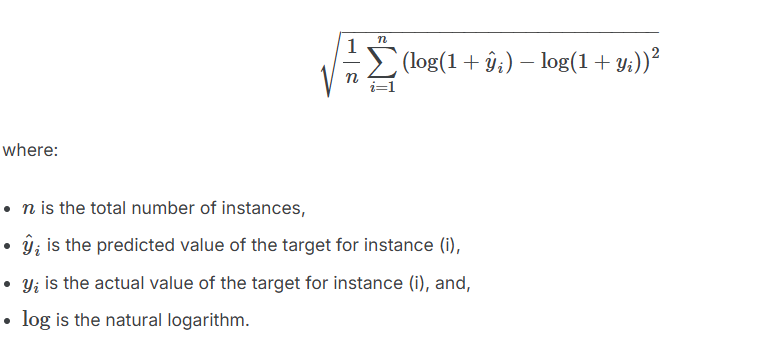

Do các mô hình hiện tại không hỗ trợ trực tiếp tham số RMSLE cho hàm mất mát, chúng ta sẽ sử dụng RMSE làm hàm mất mát mặc định. Tuy nhiên, để có thể tính được RMSLE, chúng ta sẽ áp dụng phép logarit trên biến doanh thu trước khi truyền vào mô hình

In [111]:
def rmsle(y_true, y_pred):

    # Hàm tính rmsle

    log_true = np.log1p(y_true)

    log_pred = np.log1p(y_pred)

    rmsle_value = np.sqrt(np.mean((log_true - log_pred) ** 2))

    return rmsle_value


Chia tập dữ liệu

In [ ]:
train = df_dummi[df_dummi['date'] < '2017-08-16']
test = df_dummi[df_dummi['date'] >= '2017-08-16']

In [ ]:
X_train = train.drop(['date', 'id', 'sales'], axis =1)
y_train = train['sales']


## Mô hình kinh điển trong bài toán dự báo - Linear Regression

Huấn luyện mô hình

In [ ]:
lr = LinearRegression()
lr.fit(X_train,np.log1p(y_train))

LinearRegression()

In [112]:
def make_predictions(model, test):
    pred_df = pd.DataFrame()
    id_df = pd.DataFrame()
    id_df['id'] = test['id'].copy()
    id_df.reset_index(drop=True, inplace=True)
    # xgb_test = test.drop(['id','date','store_nbr','family'], axis =1)
    xgb_test = test.drop(['id','date','sales'], axis =1)

    # pred_column_0 = model.predict(xgb_test)
    # pred_column_0 = pred_column_0[:,0]
    xgb_pred = pd.Series(model.predict(xgb_test))
    xgb_pred[ xgb_pred < 0]= 0
    xgb_pred = np.expm1(xgb_pred)
    pred_df['sales'] = xgb_pred
    pred_df['id'] = id_df['id']
    return pred_df

In [ ]:
y_pred = make_predictions(lr, test)

In [ ]:
df_pred = zero_unused_families(df_zeros, y_pred, df_unfamily)
df_pred = zero_unused_families(df_21_day_zeros, df_pred, df_unfamily)

In [ ]:
df_pred.to_csv('LinerRegression_zero_sale.csv', index=False)

Kết quả chạy trên tập test khi áp dụng Linear Regression cho kết quả rmsle là **0.99116**

Kết quả chạy khi thêm việc mặc định dự báo các mặt hàng có doanh thu là 0 là : **0.98246** ( Kết quả tốt hơn )

# Kết hợp thêm phân tích time-series (Chuỗi thời gian)

Có tổng cộng 1782 chuỗi thời gian trong tập dữ liệu (Tương ứng với 54 cửa hàng x 33 mặt hàng) bắt đầu từ 01-01-2013 -> 31-08-2017

Chúng ta sẽ minh họa việc phân tích chuỗi thời gian trên một chuỗi cụ thể, do không thể vẽ hết các chuỗi trên một biểu đồ cụ thể được.

Dưới đây là chuỗi thời gian về doanh thu trung bình của mặt hàng **BREAD/BAKERY** trong khoảng thời gian từ 01-01-2016 -> 30-06-2016

In [113]:
daily_avg_sales = sales_merged[(sales_merged['date'].dt.year == 2016) &(sales_merged['date'].dt.month <= 7)& (sales_merged['family'] == 'BREAD/BAKERY')].groupby('date')['sales'].mean()

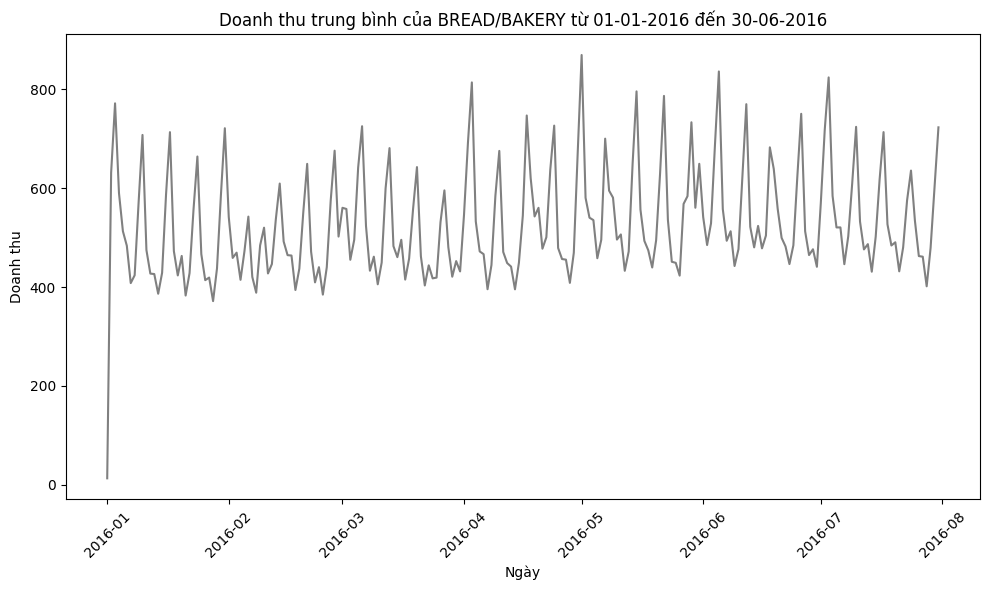

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(daily_avg_sales.index, daily_avg_sales, label='Doanh thu ', color='gray', linestyle='-')

plt.title('Doanh thu trung bình của BREAD/BAKERY từ 01-01-2016 đến 30-06-2016')
plt.xlabel('Ngày')
plt.ylabel('Doanh thu')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [115]:
def hienthi(X_time):
  model_test = LinearRegression()
  model_test.fit(X_time, daily_avg_sales)
  pred_test = model_test.predict(X_time)
  df = pd.DataFrame({
      'Ngày': daily_avg_sales.index,
      'Doanh thu thực tế': daily_avg_sales.values,
      'Dự báo': pred_test
  })
  r2 = r2_score(daily_avg_sales, pred_test)
  fig = px.line(df, x='Ngày', y=['Doanh thu thực tế', 'Dự báo'],
                labels={'Ngày': 'Ngày', 'value': 'Doanh thu trung bình'},
                title=f'Doanh thu trung bình theo ngày của mặt hàng với BREAD/BAKERY với r2-score : {r2:.2f}')

  fig.update_xaxes(tickangle=45)

  fig.show()


Phân tích chuỗi thời gian là quá trình xác định các đặc điểm theo thời gian như xu hướng, tính mùa vụ, và các yếu tố chu kỳ, nhằm phục vụ cho việc dự báo các giá trị trong tương lai.

Time Series = Trend + Seasson + Cycle + Error

Ở đây :
- Trend là xu hướng của dữ liệu
- Seasson là tính theo mùa của dữ liệu
- Cycle là chu kì của dữ liệu
- Error là các lỗi mà mô hình của chúng ta chưa thể dự đoán được

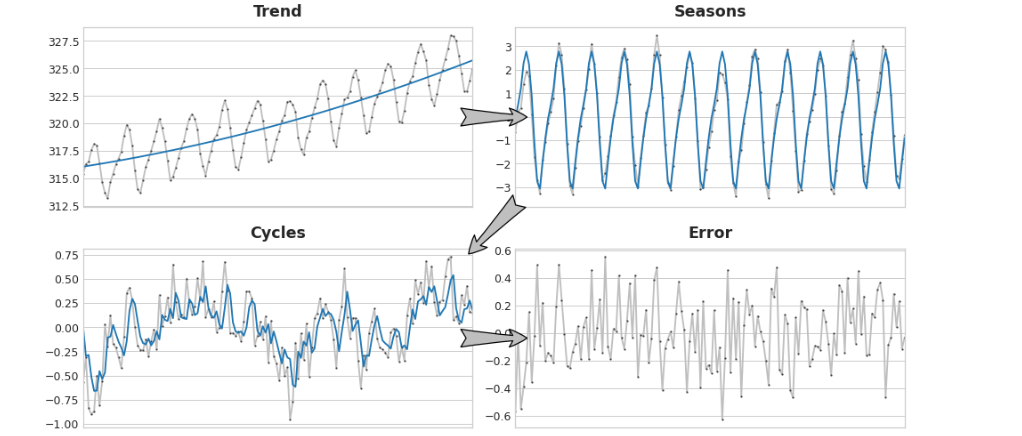

Như hình trên, khi chúng ta xác định được các tính năng này sẽ giúp mô hình đưa ra dự đoán vừa khớp với thực tế hơn

## Trend

Xu hướng chính là một đường thẳng tuyến tính giúp mô hình học được xu hướng từ dữ liệu.Xu hướng có thể tăng hoặc giảm, hoặc ổn định. Đường xu hướng bậc càng cao càng khớp với dữ liệu huấn luyện. Tuy nhiên nếu bậc cao quá sẽ dẫn đến một vài trường hợp xấu:

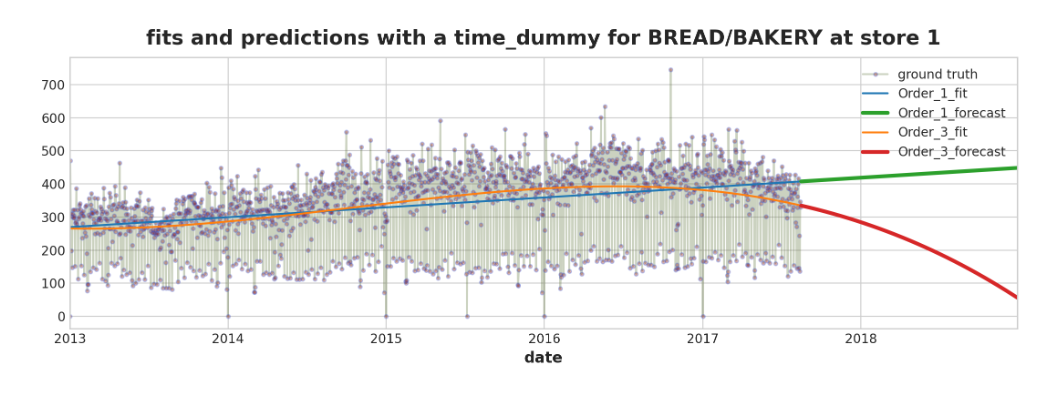

Hình trên cho thấy với xu hướng Bậc 3 thì mô hình sẽ quá khớp với dữ liệu dẫn đến dự đoán doanh thu tăng trưởng âm giảm mạnh (thực tế hoàn toàn không như vậy). Trong khi đó, Bậc 1 cho dự đoán ổn định và hợp lí hơn.

In [116]:
dp = DeterministicProcess(
    index= daily_avg_sales.index,
    constant=False,
    order=1,
)
X_time = dp.in_sample()
print('Thuộc tính đầu vào')
X_time

Thuộc tính đầu vào


,trend
date,
2016-01-01,1.0
2016-01-02,2.0
2016-01-03,3.0
2016-01-04,4.0
2016-01-05,5.0
...,...
2016-07-27,209.0
2016-07-28,210.0
2016-07-29,211.0


In [117]:
hienthi(X_time)

Với việc sử dụng duy nhất thuộc tính trend (xu hướng). Mô hình trên có chỉ số r2-score là 0.05 ( tức là mô hình nắm bắt được 5% đặc điểm của dữ liệu).

## Seasson

Tính mùa vụ. Chuỗi thời gian có thể có sự thay đổi lặp lại theo một chu kì cụ thể chẳng hạn như theo mùa, theo năm,...

Chúng ta sử dụng biểu đồ periodogram để biến động của các chu kì trong chuỗi thời gian dưới dạng tần số. Tần số đỉnh càng cao thì chu kì đó càng mạnh

In [118]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 6))

    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Biểu đồ phân bổ tần suất doanh thu của mặt hàng BREAD/BAKERY từ 01-01-2016 đến 30-06-2016


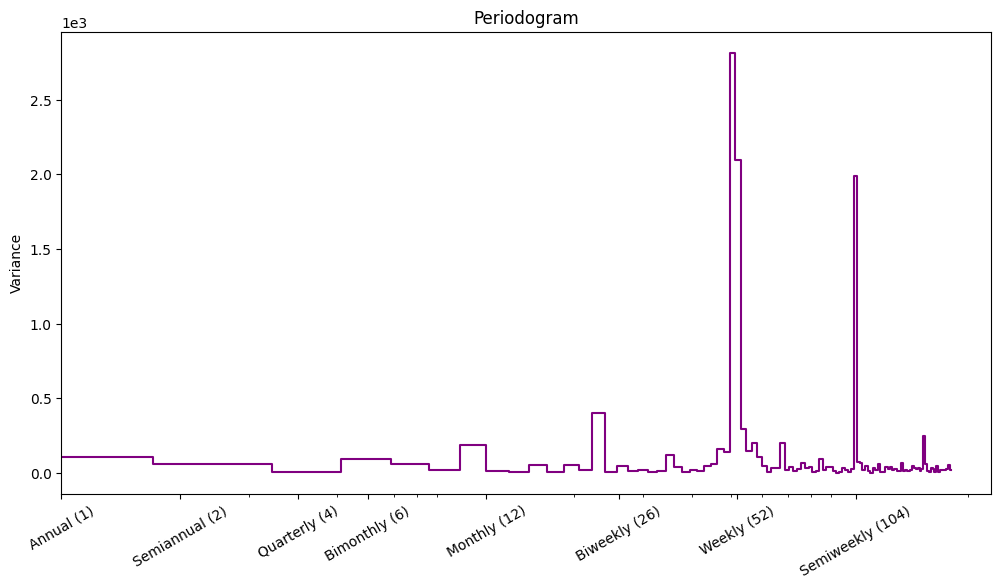

In [119]:
print('Biểu đồ phân bổ tần suất doanh thu của mặt hàng BREAD/BAKERY từ 01-01-2016 đến 30-06-2016')
plot_periodogram(daily_avg_sales);

Nhận thấy tần suất theo tuần là rõ rệt nhất. Chúng ta sẽ thêm thuộc tính ngày trong tuần để mô hình học thêm yếu tố chu kì

In [120]:
dp = DeterministicProcess(
    index= daily_avg_sales.index,
    constant=False,
    order=1,
    seasonal = True # thêm thuộc tính ngày trong tuần
)
X_time = dp.in_sample()
print('Thuộc tính đầu vào')
X_time

Thuộc tính đầu vào


,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)"
date,,,,,,,,
2016-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2016-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2016-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2016-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2016-07-27,209.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-07-28,210.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-07-29,211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
hienthi(X_time)

Lúc này r2-score là 0.74 (Mô hình đã nắm bắt được 74% đặc điểm của dữ liệu, tức là còn khoảng 26% dữ liệu là mô hình không dự đoán được).

## Cycle

Chu kì cũng là một sự thay đổi có quy luật nhưng không tuân theo mốc thời gian cố định như mùa, hàng năm hay hàng tuần,... Đây có thể là các kì suy thoái kinh tế,... và không có tính chất lặp lại đều đặn.

Những thay đổi này khó có thể nắm bắt một cách rõ ràng. Vì vậy, ở đây chúng ta sẽ tạo ra các biến gọi là `lag feature` (Tính năng trễ). Đây là các giá trị doanh thu trong quá khứ, giúp mô hình nhận diện các mối quan hệ lặp lại giữa doanh thu quá khứ và hiện tại, mà không nhất thiết phải tuân theo một mốc thời gian cố định.

Chúng ta sẽ thử thêm 1 tính năng trễ là doanh thu của ngày hôm trước xem kết quả ra sao

In [122]:
dp = DeterministicProcess(
    index= daily_avg_sales.index,
    constant=False,
    order=1,
    seasonal=True,
)
X_time = dp.in_sample()
X_time['lag'] = daily_avg_sales.shift(1) # Thêm tính năng trễ
X_time['lag'] = X_time['lag'].fillna(0)
X_time

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",lag
date,,,,,,,,,
2016-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2016-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.848151
2016-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,631.407043
2016-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,771.799622
2016-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,590.167358
...,...,...,...,...,...,...,...,...,...
2016-07-27,209.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,462.656433
2016-07-28,210.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,461.405121
2016-07-29,211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,401.468353


In [123]:
hienthi(X_time)

Lúc này Mô hình hiểu được 82% đặc điểm từ dữ liệu, nhiều hơn so với lúc trước (74%)

Số lượng tính năng trễ cần chọn sẽ nói ở sau, hiện tại trong chuỗi thời gian ví dụ này chúng ta chỉ chọn 1

## Error

Error (lỗi) chính là những giá trị còn lại mà mô hình không học được sau khi đã loại bỏ xu hướng, tính mùa vụ và chu kì. Mục tiêu là làm giảm lỗi này đi càng ít càng tốt.

Tuy nhiên, việc thêm các tính năng ngày lễ đã giúp mô hình giảm đáng kể các lỗi, vì mô hình có thể dự đoán chính xác sự thay đổi lớn trong doanh thu vào các ngày lễ

In [124]:
df_joined = pd.merge(X_time, events, left_index=True, right_on='date', how='left')
df_joined = pd.merge(df_joined, local[['date', 'holiday_local']], on='date', how='left')
df_joined = pd.merge(df_joined, regional[['date', 'holiday_regional']], on='date', how='left')
df_joined = pd.merge(df_joined, national[['date', 'holiday_national']], on='date', how='left')
column_to_dummie = ['events',	'holiday_local',	'holiday_regional',	'holiday_national']
df_joined , _ = one_hot_encode(df=df_joined, columns=column_to_dummie, nan_dummie=False, dropfirst=False)
df_joined = df_joined.drop_duplicates(subset='date', keep='first')
df_joined = df_joined.set_index('date')
df_joined.head()

,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)",lag,events_Dia_de_la_Madre,events_Terremoto_Manabi,holiday_local_Cantonizacion,holiday_local_Fundacion,holiday_regional_Provinicializacion,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_la_Madre,holiday_national_Dia_del_Trabajo,holiday_national_Primer_dia_del_ano,holiday_national_Viernes_Santo
date,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,False,False,False,False,False,False,False,False,False,True,False
2016-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.848151,False,False,False,False,False,False,False,False,False,False,False
2016-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,631.407043,False,False,False,False,False,False,False,False,False,False,False
2016-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,771.799622,False,False,False,False,False,False,False,False,False,False,False
2016-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,590.167358,False,False,False,False,False,False,False,False,False,False,False


In [125]:
hienthi(df_joined)

Sau khi thêm thuộc tính các ngày lễ, mô hình tăng từ 82 -> 86%. Giúp mô hình dự đoán lỗi tốt hơn.

Bằng việc chỉ sử dụng phân tích chuỗi thời gian, mô hình đã nắm bắt được 86% so với doanh thu thực tế.

## Thực hiện thêm các tính năng chuỗi thời gian vào tập dữ liệu chính

In [126]:
print('Danh sách các thuộc tính hiện tại')
sales_merged.head()

Danh sách các thuộc tính hiện tại


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday_local,holiday_regional,holiday_national,events
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN


Thêm xu hướng và tính mùa vụ theo ngày trong tuần

In [127]:
sales_merged['trend'] = pd.factorize(sales_merged['date'])[0] + 1
sales_merged['day_name'] = sales_merged['date'].dt.strftime('%A')
sales_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday_local,holiday_regional,holiday_national,events,trend,day_name
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN,1,Tuesday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN,1,Tuesday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN,1,Tuesday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN,1,Tuesday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Primer dia del ano,NaN,1,Tuesday


Thêm `Lag feature`- tính năng trễ

- Chúng ta sẽ sử dụng doanh thu của các ngày trong quá khứ trong vòng 90 ngày trở lại. Các tính năng trễ sau 90 ngày không giúp cải thiện hiệu suất của mô hình, thậm chí làm giảm đáng kể độ chính xác của dự đoán.

- Trong bài toán này, chúng ta chọn các giá trị trễ lần lượt là 16, 21, 30, 45, 60, 90 ngày vì mục tiêu là dự đoán doanh thu trong 15 ngày tiếp theo. Do đó, trong khoảng thời gian này, mô hình không có thông tin về doanh thu của các ngày trong vòng 15 ngày này. Việc chọn các giá trị trễ này giúp mô hình học được các xu hướng dài hạn hơn, đồng thời vẫn giữ được sự phù hợp với dữ liệu có sẵn.

- Ngoaì ra, chúng ta sử dụng thêm trung bình động độ trễ, tức là doanh thu trung bình trong quá khứ trong một khoảng thời gian. Ví dụ như doanh thu trung bình trong 30 ngày trong quá khứ. Việc lấy thêm tính năng trung bình động giúp mô hình nắm bắt được những xu hướng dài hơn thay vì chỉ tập trung vào các giá trị doanh thu cũ. Ví dụ khi doanh thu trong vòng 30 ngày gần đây có những ngày rất cao, những ngày rất thấp thì khi biết trung bình động, giả sử trung bình động thấp thì mô hình sẽ đưa ra dự đoán thiên hướng thấp hơn. Tránh bị ảnh hưởng quá lớn bởi những ngày có doanh thu cao bất thường.

In [128]:
def create_lags(df):

    new_df = df.copy()

    keys = ['store_nbr', 'family']

    val = 'sales'
    # lags = [ 16, 21, 30, 45, 60, 90, 120, 365, 730]
    lags = [ 16, 21, 30, 45, 60, 90]
    #lags = [x for x in range(1,64)]


    for lag in lags:

        new_df['lag_' + str(lag)] = new_df.groupby(keys)[val].transform(lambda x: x.shift(lag))

    return new_df



In [129]:
def create_rolling_mean(df):



    new_df = df.sort_values(["store_nbr", "family", "date"]).copy()

    #shifts = [20, 30, 45, 60, 90, 120, 365, 730]


    for i in [20]:

        new_df["SMA"+str(i)+"_sales_lag16"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(16).values

        new_df["SMA"+str(i)+"_sales_lag30"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(30).values

        new_df["SMA"+str(i)+"_sales_lag60"] = new_df.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(60).values


    return new_df

In [130]:
sales_merged = create_lags(sales_merged )
sales_merged = create_rolling_mean(sales_merged)
#df_transform = create_steps(df_transform)

In [131]:
sales_merged.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,day_name,lag_16,lag_21,lag_30,lag_45,lag_60,lag_90,SMA20_sales_lag16,SMA20_sales_lag30,SMA20_sales_lag60
3023921,3022139,2017-08-27,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,Sunday,0.0,0.0,4.0,0.0,1.0,7.0,3.30,3.20,3.0
3025703,3023921,2017-08-28,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,Monday,1.0,0.0,4.0,0.0,1.0,1.0,3.10,3.10,3.0
3027485,3025703,2017-08-29,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,Tuesday,2.0,12.0,4.0,2.0,0.0,7.0,3.15,2.80,2.8
3029267,3027485,2017-08-30,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,Wednesday,0.0,4.0,4.0,5.0,2.0,0.0,2.80,2.85,2.8
3031049,3029267,2017-08-31,54,SEAFOOD,NaN,0,El Carmen,Manabi,C,3,...,Thursday,3.0,2.0,3.0,3.0,3.0,0.0,2.80,2.95,2.7


In [132]:
sales_merged = sales_merged.apply(lambda x: x.astype('category') if x.dtype == 'object' else x)

category_columns = sales_merged.select_dtypes(include='category').columns.tolist()
category_columns


['store_nbr',
 'family',
 'city',
 'state',
 'type',
 'cluster',
 'holiday_local',
 'holiday_regional',
 'holiday_national',
 'events',
 'day_name']

In [133]:
df_timeseries , _ = one_hot_encode(df=sales_merged, columns=category_columns, nan_dummie=False, dropfirst=False)

Do có thêm các tính năng trễ là kiểu số nên chúng ta sẽ scale lại dữ liệu để Linear Regression học tốt hơn

In [134]:
numerical_columns = ['trend', 'onpromotion','lag_16','lag_21','lag_30','lag_45','lag_60','lag_90',
                    'SMA20_sales_lag16' ,'SMA20_sales_lag16','SMA20_sales_lag16']


In [135]:
scaler = RobustScaler()

# Chỉ định cột cần scale
df_timeseries[numerical_columns] = scaler.fit_transform(df_timeseries[numerical_columns])

In [136]:
df_timeseries.tail()

,id,date,sales,onpromotion,trend,lag_16,lag_21,lag_30,lag_45,lag_60,...,events_Dia_de_la_Madre,events_Terremoto_Manabi,events_futbol,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
3023921,3022139,2017-08-27,NaN,0.0,0.945562,-0.070485,-0.070485,-0.052863,-0.070695,-0.066372,...,False,False,False,False,False,False,True,False,False,False
3025703,3023921,2017-08-28,NaN,0.0,0.946746,-0.066079,-0.070485,-0.052863,-0.070695,-0.066372,...,False,False,False,False,True,False,False,False,False,False
3027485,3025703,2017-08-29,NaN,0.0,0.947929,-0.061674,-0.017621,-0.052863,-0.061858,-0.070796,...,False,False,False,False,False,False,False,False,True,False
3029267,3027485,2017-08-30,NaN,0.0,0.949112,-0.070485,-0.052863,-0.052863,-0.048603,-0.061947,...,False,False,False,False,False,False,False,False,False,True
3031049,3029267,2017-08-31,NaN,0.0,0.950296,-0.057269,-0.061674,-0.057269,-0.057440,-0.057522,...,False,False,False,False,False,False,False,True,False,False


### Linear Regression RMSLE : 0.85493

In [ ]:
train = df_timeseries[df_timeseries['date'] < '2017-08-16']
train = train.dropna()
test = df_timeseries[df_timeseries['date'] >= '2017-08-16']
X_train = train.drop(['date', 'id', 'sales'], axis =1)
y_train = train['sales']

In [ ]:
X_train.shape

(2621685, 185)

In [ ]:
lr_time = LinearRegression()
lr_time.fit(X_train,np.log1p(y_train))

LinearRegression()

In [ ]:
y_pred = make_predictions(lr_time, test)

In [ ]:
df_pred = zero_unused_families(df_zeros, y_pred, df_unfamily)
df_pred = zero_unused_families(df_21_day_zeros, df_pred, df_unfamily)
df_pred.to_csv('LinerRegression_timeseries_minmax.csv', index=False)

### Xgboost RMSLE 0.42606

In [137]:
train = df_timeseries[(df_timeseries['date'] > '2015-12-31') & (df_timeseries['date'] < '2017-08-16')]
test = df_timeseries[df_timeseries['date'] >= '2017-08-16']
X_train = train.drop(['date', 'id', 'sales'], axis =1)
y_train = train['sales']
xgb = XGBRegressor()
xgb.fit(X_train,np.log1p(y_train))
y_pred = make_predictions(xgb, test)
df_pred = zero_unused_families(df_zeros, y_pred, df_unfamily)
df_pred = zero_unused_families(df_21_day_zeros, df_pred, df_unfamily)
df_pred.to_csv('XGBoost_timeseries_sau2015.csv', index=False)

### LightBM RMSLE 0.44041

In [ ]:
lgb = LGBMRegressor()
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
lgb.fit(X_train,np.log1p(y_train))
y_pred = make_predictions(lgb, test)
df_pred = zero_unused_families(df_zeros, y_pred, df_unfamily)
df_pred = zero_unused_families(df_21_day_zeros, df_pred, df_unfamily)
df_pred.to_csv('LGBM_timeseries.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.223848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3107
[LightGBM] [Info] Number of data points in the train set: 2782065, number of used features: 185
[LightGBM] [Info] Start training from score 3.158756


rmsle : 0.44041

### Catboost RMSLE 0.42067

In [148]:
column_4 = ['holiday_local',
 'holiday_regional',
 'holiday_national',
 'events']
df_timeseries , _ = one_hot_encode(df=sales_merged, columns=column_4, nan_dummie=False, dropfirst=False)
category_columns2 = df_timeseries.select_dtypes(include='category').columns.tolist()
category_columns2

['store_nbr', 'family', 'city', 'state', 'type', 'cluster', 'day_name']

In [149]:
train = df_timeseries[df_timeseries['date'] < '2017-08-16']
#train = train.dropna()
test = df_timeseries[df_timeseries['date'] >= '2017-08-16']
# Thay NaN bằng 0 trong toàn bộ DataFrame
X_train = train.drop(['date', 'id', 'sales'], axis =1)
y_train = train['sales']
cat = CatBoostRegressor( task_type='GPU')
cat.fit(X_train,np.log1p(y_train),cat_features=category_columns2)
y_pred = make_predictions(cat, test)
df_pred = zero_unused_families(df_zeros, y_pred, df_unfamily)
df_pred = zero_unused_families(df_21_day_zeros, df_pred, df_unfamily)
df_pred.to_csv('Catboost_timeseries.csv', index=False)

Learning rate set to 0.114163
0:	learn: 2.4017961	total: 591ms	remaining: 9m 50s
1:	learn: 2.1706804	total: 994ms	remaining: 8m 15s
2:	learn: 1.9685286	total: 1.42s	remaining: 7m 50s
3:	learn: 1.7917436	total: 1.82s	remaining: 7m 34s
4:	learn: 1.6348062	total: 2.23s	remaining: 7m 22s
5:	learn: 1.5012109	total: 2.65s	remaining: 7m 19s
6:	learn: 1.3850497	total: 3.05s	remaining: 7m 13s
7:	learn: 1.2836424	total: 3.46s	remaining: 7m 9s
8:	learn: 1.1961406	total: 3.87s	remaining: 7m 6s
9:	learn: 1.1201448	total: 4.29s	remaining: 7m 5s
10:	learn: 1.0575057	total: 4.75s	remaining: 7m 7s
11:	learn: 1.0037497	total: 5.24s	remaining: 7m 11s
12:	learn: 0.9577432	total: 5.64s	remaining: 7m 8s
13:	learn: 0.9188498	total: 6.12s	remaining: 7m 10s
14:	learn: 0.8870402	total: 6.54s	remaining: 7m 9s
15:	learn: 0.8577636	total: 6.97s	remaining: 7m 8s
16:	learn: 0.8352373	total: 7.38s	remaining: 7m 6s
17:	learn: 0.8153033	total: 7.82s	remaining: 7m 6s
18:	learn: 0.7977818	total: 8.25s	remaining: 7m 6s
19

## Catboost cho kết quả tốt nhất nên sẽ lựa chọn sử dụng Catboost cho mô hình cuối cùng

## Xây dựng nhiều mô hình

Hiện tại, chúng ta đang sử dụng một mô hình để dự đoán cho tất cả 1782 chuỗi thời gian. Nếu xây dựng một mô hình riêng cho từng chuỗi thời gian, kết quả có thể tốt hơn. Tuy nhiên, việc xây dựng 1782 mô hình là quá phức tạp và tốn kém.

Một phương án khả thi hơn là xây dựng các mô hình riêng biệt cho từng cửa hàng và từng mặt hàng. Cụ thể, có thể áp dụng các trường hợp sau:

- Trường hợp 1: Xây dựng 54 mô hình cho 54 cửa hàng.
- Trường hợp 2: Xây dựng 33 mô hình cho 33 mặt hàng.
- Trường hợp 3: Giữ nguyên mô hình hiện tại để dự đoán tất cả 1782 chuỗi thời gian.

### Một mô hình dự đoán cho tất cả 1782 chuỗi thời gian (RMSLE :0.42067)

Hiện đang có chỉ số RMSLE là 0.42067

### 54 mô hình mỗi cửa hàng (RMSLE: 0.41424)

In [137]:
store_columns = df_train['store_nbr'].unique()
family_columns = df_train['family'].unique()

In [138]:
column_4 = ['holiday_local',
 'holiday_regional',
 'holiday_national',
 'events']
df_timeseries , _ = one_hot_encode(df=sales_merged, columns=column_4, nan_dummie=False, dropfirst=False)
category_columns2 = df_timeseries.select_dtypes(include='category').columns.tolist()
category_columns2

['store_nbr', 'family', 'city', 'state', 'type', 'cluster', 'day_name']

In [139]:
train = df_timeseries[ (df_timeseries['date'] < '2017-08-16')]
test = df_timeseries[df_timeseries['date'] >= '2017-08-16']

In [140]:
### 54 MODELS - 1 PER SHOP (MULTIPLE FAMILIES PER MODEL)
NR_OF_SHOPS = store_columns
models_per_shop = [None] *  len(NR_OF_SHOPS)
a_ite = 0

for i in NR_OF_SHOPS:
    train_per_shop = train[train['store_nbr'] == i]
    y_per_shop = np.log1p(train_per_shop['sales'])
    x_per_shop = train_per_shop.drop(['date', 'id', 'sales'], axis =1)

    print(f"Training model {i}...")
    model = CatBoostRegressor( task_type='GPU',silent=True)
    model.fit(x_per_shop,y_per_shop,cat_features=category_columns2)
    models_per_shop[a_ite] = model
    a_ite = a_ite + 1

Training model 1...
Training model 10...
Training model 11...
Training model 12...
Training model 13...
Training model 14...
Training model 15...
Training model 16...
Training model 17...
Training model 18...
Training model 19...
Training model 2...
Training model 20...
Training model 21...
Training model 22...
Training model 23...
Training model 24...
Training model 25...
Training model 26...
Training model 27...
Training model 28...
Training model 29...
Training model 3...
Training model 30...
Training model 31...
Training model 32...
Training model 33...
Training model 34...
Training model 35...
Training model 36...
Training model 37...
Training model 38...
Training model 39...
Training model 4...
Training model 40...
Training model 41...
Training model 42...
Training model 43...
Training model 44...
Training model 45...
Training model 46...
Training model 47...
Training model 48...
Training model 49...
Training model 5...
Training model 50...
Training model 51...
Training model 52.

In [141]:
### preds by models for each store
merged_df = pd.DataFrame()

for i, value in enumerate(NR_OF_SHOPS):
    test_per_shop = test[test['store_nbr'] == value]
    preds_df = make_predictions(models_per_shop[i], test_per_shop)
    merged_df = pd.concat([merged_df, preds_df])

preds_models_per_shop = merged_df.copy()
preds_models_per_shop = preds_models_per_shop.sort_values('id', ascending=True)
preds_models_per_shop = preds_models_per_shop.reset_index(drop=True)
preds_models_per_shop = zero_unused_families(df_zeros, preds_models_per_shop, df_unfamily)
preds_models_per_shop = zero_unused_families(df_21_day_zeros, preds_models_per_shop, df_unfamily)
preds_models_per_shop.to_csv('Catboost_54_model.csv', index=False)

### 33 mô hình mỗi mặt hàng (RMSLE: 0.40105)


In [142]:
#### 33 MODELS - 1 PER FAMILY (MULTIPLE STORES PER MODEL)
NR_OF_FAMILIES = family_columns
models_per_family = [None] *  len(NR_OF_FAMILIES)

b_ite = 0
for i in NR_OF_FAMILIES:
    train_per_family = train[train['family'] == i]
    y_per_family = np.log1p(train_per_family['sales'])
    x_per_family = train_per_family.drop(['date', 'id', 'sales'], axis =1)

    print(f"Training model {i}...")
    model = CatBoostRegressor( task_type='GPU',silent=True)
    model.fit(x_per_family,y_per_family,cat_features=category_columns2)
    models_per_family[b_ite] = model
    b_ite = b_ite + 1

Training model AUTOMOTIVE...
Training model BABY CARE...
Training model BEAUTY...
Training model BEVERAGES...
Training model BOOKS...
Training model BREAD/BAKERY...
Training model CELEBRATION...
Training model CLEANING...
Training model DAIRY...
Training model DELI...
Training model EGGS...
Training model FROZEN FOODS...
Training model GROCERY I...
Training model GROCERY II...
Training model HARDWARE...
Training model HOME AND KITCHEN I...
Training model HOME AND KITCHEN II...
Training model HOME APPLIANCES...
Training model HOME CARE...
Training model LADIESWEAR...
Training model LAWN AND GARDEN...
Training model LINGERIE...
Training model LIQUOR,WINE,BEER...
Training model MAGAZINES...
Training model MEATS...
Training model PERSONAL CARE...
Training model PET SUPPLIES...
Training model PLAYERS AND ELECTRONICS...
Training model POULTRY...
Training model PREPARED FOODS...
Training model PRODUCE...
Training model SCHOOL AND OFFICE SUPPLIES...
Training model SEAFOOD...


In [143]:
### preds by models for each family
merged_df = pd.DataFrame()

for i, value in enumerate(NR_OF_FAMILIES):
    test_per_family = test[test['family'] == value]
    preds_df = make_predictions(models_per_family[i], test_per_family)
    merged_df = pd.concat([merged_df, preds_df])

preds_models_per_family = merged_df.copy()
preds_models_per_family = preds_models_per_family.sort_values('id', ascending=True)
preds_models_per_family = preds_models_per_family.reset_index(drop=True)
preds_models_per_family = zero_unused_families(df_zeros, preds_models_per_family, df_unfamily)
preds_models_per_family = zero_unused_families(df_21_day_zeros, preds_models_per_family, df_unfamily)
preds_models_per_family.to_csv('Catboost_33_model.csv', index=False)

### Kết luận

RMSLE của từng mô hình:
- Single model : **0.42067**
- Multiple store model : **0.41424**
- Multiple family model : **0.40105**

Trường hợp chia từng mô hình cho từng mặt hàng đạt kết quả tốt nhất. Chúng ta sẽ lựa chọn làm mô hình cuối cùng

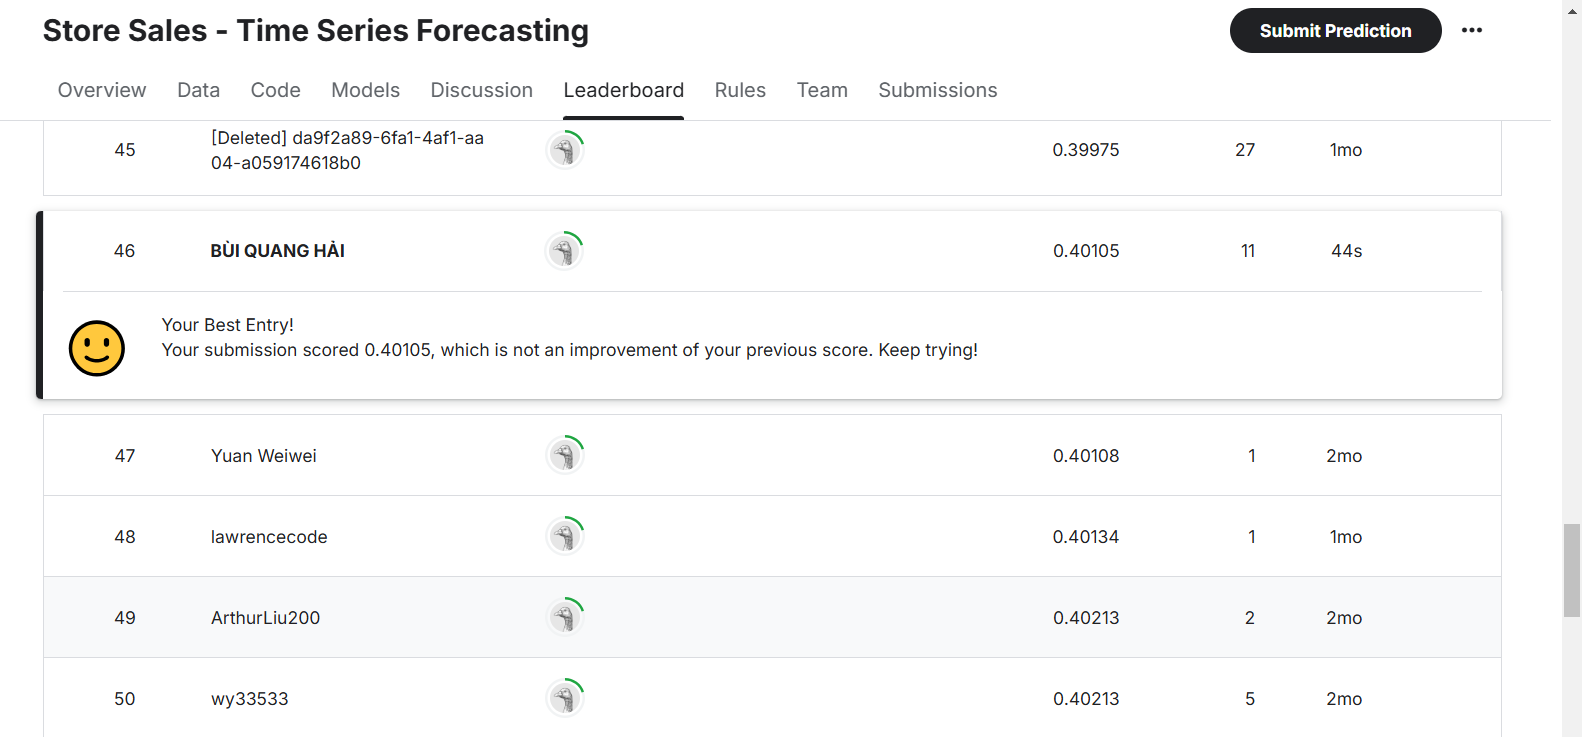

Mô hình cuối cùng đặt hiệu số thứ hạng 46/677 (~6%) với RMSLE là 0.40105.